In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
import pandas as pd

train_df = pd.read_pickle('./mvc_train.pkl')
test_df = pd.read_pickle('./mvc_test.pkl')

In [3]:
train_df.sample(10)

,filename,attributes
24264,category/Jeans/p8656952_s3455271_v1.jpg,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
68558,category/Coats_Outerwear/p8637693_s3412748_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
82631,category/Shirts_Tops/p8454052_s2992958_v3.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
31329,category/Shirts_Tops/p8328345_s2702933_v3.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
6815,category/Dresses/p8548333_s3208418_v1.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
84549,category/Pants/p8139904_s2252989_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
68004,category/Pants/p8573405_s3267072_v2.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54909,category/Shirts_Tops/p8525291_s3151394_v3.jpg,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
32398,category/Shirts_Tops/p8556599_s3227780_v0.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
84671,category/Jeans/p8682432_s3511320_v2.jpg,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
label = ['BoardShorts',
'ButtonUpShirts',
'Crew',
'Denim',
'FloralPrint',
'GraphicPrint',
'Halter',
'Hood',
'HorizontalStripes',
'Insulated',
'Leggings',
'LongSleeves',
'Mesh',
'Plaid',
'Polos',
'Scoop',
'ShortSleeves',
'Sleeveless',
'SnowPants',
'Stripes',
'VerticalStripes',
'Vests',
'Vneck',
'Zipper',
'halfZip',
'quarter3Zip',
'quarterZip']

In [5]:
IMG_SIZE = 256
CROP_SIZE = 224

def train_preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image/127.5) - 1
    image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CROP_SIZE, CROP_SIZE])
    #image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    image = (image/127.5) - 1
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

In [6]:
def train_load_and_preprocess_image(path):
    image = tf.read_file(path)
    return train_preprocess_image(image)

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [7]:
import numpy as np
train_paths = train_df['filename'].tolist()
train_label = np.asarray(train_df['attributes'].tolist())

test_paths = test_df['filename'].tolist()
test_label = np.asarray(test_df['attributes'].tolist())

In [8]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)

train_image_ds = train_path_ds.map(train_load_and_preprocess_image)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [9]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_label, tf.int32))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_label, tf.int32))

In [10]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
print(train_image_label_ds)
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
print(test_image_label_ds)

<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>


In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.

train_image_label_ds = train_image_label_ds.shuffle(buffer_size=512).repeat()
train_image_label_ds = train_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [12]:
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [13]:
for image_batch, label_batch in train_image_label_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 27)


In [14]:
IMG_SHAPE = (CROP_SIZE, CROP_SIZE, 3)


#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
#with tf.device('/cpu:0'): 
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [16]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.input_shape)

0 [(None, 224, 224, 3)]
1 (None, 224, 224, 3)
2 (None, 225, 225, 3)
3 (None, 112, 112, 32)
4 (None, 112, 112, 32)
5 (None, 112, 112, 32)
6 (None, 112, 112, 32)
7 (None, 112, 112, 32)
8 (None, 112, 112, 32)
9 (None, 112, 112, 16)
10 (None, 112, 112, 16)
11 (None, 112, 112, 96)
12 (None, 112, 112, 96)
13 (None, 112, 112, 96)
14 (None, 113, 113, 96)
15 (None, 56, 56, 96)
16 (None, 56, 56, 96)
17 (None, 56, 56, 96)
18 (None, 56, 56, 24)
19 (None, 56, 56, 24)
20 (None, 56, 56, 144)
21 (None, 56, 56, 144)
22 (None, 56, 56, 144)
23 (None, 56, 56, 144)
24 (None, 56, 56, 144)
25 (None, 56, 56, 144)
26 (None, 56, 56, 24)
27 [(None, 56, 56, 24), (None, 56, 56, 24)]
28 (None, 56, 56, 24)
29 (None, 56, 56, 144)
30 (None, 56, 56, 144)
31 (None, 56, 56, 144)
32 (None, 57, 57, 144)
33 (None, 28, 28, 144)
34 (None, 28, 28, 144)
35 (None, 28, 28, 144)
36 (None, 28, 28, 32)
37 (None, 28, 28, 32)
38 (None, 28, 28, 192)
39 (None, 28, 28, 192)
40 (None, 28, 28, 192)
41 (None, 28, 28, 192)
42 (None, 28, 28, 

In [17]:
#with tf.device('/cpu:0'): 
#base_model.trainable = False
for layer in base_model.layers[:121]:
    layer.trainable = False
    
for layer in base_model.layers[121:]:
    layer.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
#max_pooling_layer = tf.keras.layers.GlobalMaxPooling2D()
#feature_batch_max = max_pooling_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
mid_layer = tf.keras.layers.Dense(512, activation='relu')
mid_batch = mid_layer(feature_batch_average)
dropout_layer = tf.keras.layers.Dropout(0.5)
dropout_batch = dropout_layer(mid_batch)
#prediction_layer = tf.keras.layers.Dense(27, activation='sigmoid')
prediction_layer = tf.keras.layers.Dense(27)
prediction_batch = prediction_layer(mid_batch)
print(prediction_batch.shape)

(32, 27)


In [20]:
nb_train_samples = len(train_paths) 
nb_val_samples = len(test_paths) 

steps_per_epoch = nb_train_samples // BATCH_SIZE
validation_steps=nb_val_samples//BATCH_SIZE
nb_val_samples

27348

In [21]:
def weighted_loss(target, prediction):
    batch = tf.shape(target)[0]
    
    #print(batch)
    target = tf.cast(target, tf.float32)
    weight = 1-tf.divide(tf.reduce_sum(target,0, keepdims=True),tf.cast(batch, tf.float32))
    #print(weight)
    #print(loss)
    return tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=prediction, pos_weight=weight)
    
    #return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

In [22]:
#prediction = tf.convert_to_tensor(np.random.rand(8, 27), tf.float32)

print(weighted_loss(label_batch, prediction_batch))

tf.Tensor(
[[0.64147365 0.3591839  1.1978676  1.5523689  0.7434898  0.666599
  0.5517465  0.8352524  0.27311277 0.9123033  0.2625972  0.3304556
  0.6556527  1.2793586  1.6101861  0.46731555 1.0318786  0.49842745
  0.489502   0.62959814 1.6198733  0.70261484 1.2012854  0.6436937
  0.8308473  0.930652   0.43664902]
 [0.6600581  0.2614473  0.7212186  1.1202835  0.80344033 1.1214113
  0.9932485  0.9883342  0.30752337 0.77979153 0.4245547  0.5610492
  0.8705938  1.0379715  0.13048474 0.41877818 0.36270058 0.5720878
  0.96796274 0.54942644 0.8131423  0.53560567 0.55688155 0.92812026
  0.7523813  0.5652009  0.5528878 ]
 [0.5022344  0.25641143 0.6428666  0.366687   0.34947652 0.7111783
  1.2113812  1.1246498  0.13004637 0.769992   0.30982447 0.66910315
  0.45121413 0.46893364 1.7415352  0.29271138 0.6790463  0.5574274
  1.0339994  0.76592714 0.8294302  0.2864405  0.32982147 0.6915353
  1.2392417  0.6690132  0.7053613 ]
 [0.72626007 0.34964406 1.0920186  0.9988406  0.45683002 0.59205616
  0.467

when val is very slow refer this [page](https://github.com/keras-team/keras/issues/6101)

In [23]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    mid_layer,
    dropout_layer,
    prediction_layer
])

In [57]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        prediction = model(inputs)
        loss_value = weighted_loss(targets, prediction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [58]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.contrib.eager.Variable(0)

train_loss_results = []
train_accuracy_results = []

num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
    
    # Training loop - using batches of 32
    for x, y in train_image_label_ds:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                  global_step)

        # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss
        # compare predicted label to actual label


       
        epoch_accuracy(tf.cast(y,tf.bool), model(x))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                            epoch_loss_avg.result(),
                                                            epoch_accuracy.result()))    

KeyboardInterrupt: 

In [25]:
#parallel_model = multi_gpu_model(model, gpus=2)
callbacks = [
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='./mobilev2/weighted_finetune_aug.top.h5'),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./mobilev2/weighted_logs')
]

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=weighted_loss, optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_image_label_ds, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_image_label_ds, validation_steps=validation_steps, \
          workers=4, use_multiprocessing=True , callbacks=callbacks)

Epoch 1/20
3418/3418 [==============================] - 723s 211ms/step - loss: 0.0724 - binary_accuracy: 0.9706 - val_loss: 0.1629 - val_binary_accuracy: 0.9531
Epoch 2/20
3418/3418 [==============================] - 699s 205ms/step - loss: 0.0664 - binary_accuracy: 0.9729 - val_loss: 0.1171 - val_binary_accuracy: 0.9586
Epoch 3/20
3418/3418 [==============================] - 697s 204ms/step - loss: 0.0628 - binary_accuracy: 0.9743 - val_loss: 0.1002 - val_binary_accuracy: 0.9603
Epoch 4/20
3418/3418 [==============================] - 700s 205ms/step - loss: 0.0605 - binary_accuracy: 0.9751 - val_loss: 0.0936 - val_binary_accuracy: 0.9623
Epoch 5/20
3418/3418 [==============================] - 699s 205ms/step - loss: 0.0584 - binary_accuracy: 0.9760 - val_loss: 0.0989 - val_binary_accuracy: 0.9614
Epoch 6/20
3418/3418 [==============================] - 701s 205ms/step - loss: 0.0567 - binary_accuracy: 0.9765 - val_loss: 0.0905 - val_binary_accuracy: 0.9622
Epoch 7/20
3418/3418 [======

In [26]:
model.save('./mobilev2/weighted_finetune_aug.h5')

In [11]:
del mvc_label

In [12]:
#import PIL.Image as pil
IMG_SIZE = 224

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

In [13]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [14]:
path_ds = tf.data.Dataset.from_tensor_slices(filtered_image_paths)


In [15]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

W0709 12:15:34.761567 140275680081728 deprecation.py:323] From <ipython-input-15-2a9400bc986b>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0709 12:15:34.764117 140275680081728 deprecation.py:323] From <ipython-input-15-2a9400bc986b>:2: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [16]:
#paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (224, 224, 3), types: tf.float32>

In [17]:
import numpy as np

attr_np = np.asarray(filtered_attributes)

In [18]:
attr_np.shape

(136740, 27)

In [19]:
np.savez('filtered.npz', y=attr_np)

In [20]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(filtered_attributes, tf.int64))


In [21]:
for label in label_ds.take(5):
    print(label.numpy())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]


In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [23]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int64)>


In [25]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
'''
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds
'''
#ds = image_label_ds.cache(filename='./cache.tf-data')
#image_label_ds = image_label_ds.apply(
#  tf.data.experimental.shuffle_and_repeat(buffer_size=16))
#image_label_ds = image_label_ds.cache()
AUTOTUNE = tf.data.experimental.AUTOTUNE

image_label_ds = image_label_ds.shuffle(buffer_size=64)
image_label_ds = image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int64)>

In [26]:
for image_batch, label_batch in image_label_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 27)


In [27]:

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMG_SHAPE,        
                                               include_top=False,
                                               weights='imagenet')
 

In [28]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1056)


In [29]:
tf.cast(tf.shape(label_batch)[0], tf.float32)

<tf.Tensor: id=30040, shape=(), dtype=float32, numpy=32.0>

In [30]:
base_model.trainable = False
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right1_7[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left2_7[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right2_7[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left5_7[0
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 14, 14, 88)   0           separable_conv_1_bn_normal_left1_
__________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1056)


In [32]:
#flatten_layer = tf.keras.layers.Flatten()
#mid_layer = tf.keras.layers.Dense(1024, activation=tf.nn.relu)
#flatten_batch = flatten_layer(feature_batch_max)
#feature_batch_full = mid_layer(flatten_batch)
#print(feature_batch_full.shape)

In [33]:
prediction_layer = tf.keras.layers.Dense(27, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 27)


In [34]:
steps_per_epoch = image_count // BATCH_SIZE
steps_per_epoch

4273

In [35]:
def loss(y, y_):
    #y_ = model(x)
    batch=tf.cast(tf.shape(y)[0], tf.float32)
    
    
    weight = 1.0-tf.divide(tf.reduce_sum(y,0, keepdims=True),batch)
    #return weight
    #weighted_y = weight*tf.cast(y, tf.float64)
    #output = tf.cast(tf.log(y_), tf.float64)
    #return -weighted_y*output
    return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

In [36]:
#from tensorflow.keras.utils import multi_gpu_model
#adam = tf.keras.optimizers.Adam(lr=0.01)
#with tf.device('/cpu:0'):
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])
    
#parallel_model = multi_gpu_model(model, gpus=2)
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(image_label_ds, steps_per_epoch=steps_per_epoch, epochs=1)

W0709 12:16:59.787838 140275680081728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


4273/4273 [==============================] - 849s 199ms/step - loss: 0.1233 - acc: 0.9556


In [37]:
model.save('NASNetMobile_test.h5')

In [38]:
label=['BoardShorts',
'ButtonUpShirts',
'Crew',
'Denim',
'FloralPrint',
'GraphicPrint',
'Halter',
'Hood',
'HorizontalStripes',
'Insulated',
'Leggings',
'LongSleeves',
'Mesh',
'Plaid',
'Polos',
'Scoop',
'ShortSleeves',
'Sleeveless',
'SnowPants',
'Stripes',
'VerticalStripes',
'Vests',
'Vneck',
'Zipper',
'halfZip',
'quarter3Zip',
'quarterZip']

In [57]:
path='./rename/p8662407_s3467351_v1.jpg'
image = tf.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [224,224])
image /= 255.0  # normalize to [0,1] range
pred = model.predict(image[np.newaxis, ...])
indexes = np.where(pred[0,:]> 0.5)
attr=pd.Series(label)
attr.iloc[indexes]

1     ButtonUpShirts
11       LongSleeves
dtype: object

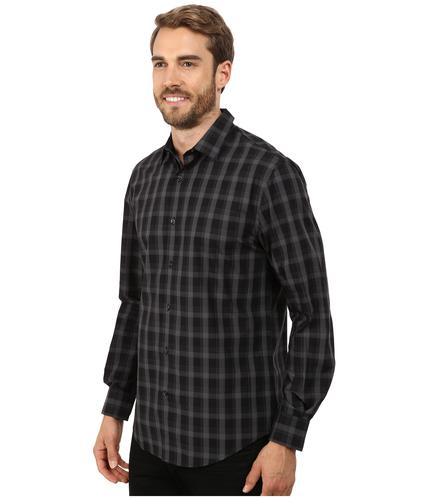

In [58]:
from IPython.display import Image
Image(path)